In [2]:
# Use DeepSurv from the repo
import deep_surv

from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline


2024-03-06 09:19:16.124191: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 09:19:16.125457: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 09:19:16.143550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 09:19:16.143573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 09:19:16.144092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
train_dataset_fp = '/home/john/network/RETFound/RETFound_MAE-main/Fundus_deepsurv/Regression/deepsurv.csv'
train_df = pd.read_csv(train_dataset_fp)
train_df.head()

,病歷號,抽菸,身高,體重,BMI,Event,高血壓,血脂異常,真實年齡,預測結果,Time
0,4385815-02-L-20170802.jpg,0,149.0,71.0,31.98,0,1.0,1.0,64,57.276570,2144
1,7093981-05-L-20200804.jpg,0,155.0,75.0,31.22,0,1.0,1.0,48,47.467750,1046
2,4940688-05-R-20230201.jpg,0,167.7,93.3,33.18,0,0.0,0.0,60,57.765377,135
3,2310298-05-L-20220708.jpg,0,162.1,69.5,26.45,0,0.0,0.0,59,63.910080,343
4,4540756-03-R-20211102.jpg,0,166.2,78.7,28.49,0,0.0,1.0,70,55.230278,591


In [4]:
train_df = train_df.drop(columns=['病歷號'])
train_df.head()

,抽菸,身高,體重,BMI,Event,高血壓,血脂異常,真實年齡,預測結果,Time
0,0,149.0,71.0,31.98,0,1.0,1.0,64,57.276570,2144
1,0,155.0,75.0,31.22,0,1.0,1.0,48,47.467750,1046
2,0,167.7,93.3,33.18,0,0.0,0.0,60,57.765377,135
3,0,162.1,69.5,26.45,0,0.0,0.0,59,63.910080,343
4,0,166.2,78.7,28.49,0,0.0,1.0,70,55.230278,591


# Transform the dataset to "DeepSurv" format
DeepSurv expects a dataset to be in the form:

    {
        'x': numpy array of float32
        'e': numpy array of int32
        't': numpy array of float32
        'hr': (optional) numpy array of float32
    }
    
You are providing me a csv, which I read in as a pandas dataframe. Then I convert the pandas dataframe into the DeepSurv dataset format above. 

In [16]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'Event', time_col= 'Time')

Now once you have your dataset all formatted, define you hyper_parameters as a Python dictionary. 
I'll provide you with some example hyper-parameters, but you should replace the values once you tune them to your specific dataset

In [17]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

Once you prepared your dataset, and defined your hyper-parameters. Now it's time to train DeepSurv!

In [18]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deep_surv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'test_experiment_sebastian'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 2000

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)

2024-03-01 13:15:11,089 - Training step 0/2000    |                         | - loss: 26.4321 - ci: 0.4219
2024-03-01 13:15:57,087 - Training step 250/2000  |***                      | - loss: 13.6282 - ci: 0.4057
2024-03-01 13:16:39,201 - Training step 500/2000  |******                   | - loss: 9.1667 - ci: 0.4185
2024-03-01 13:17:28,564 - Training step 750/2000  |*********                | - loss: 7.6608 - ci: 0.4350
2024-03-01 13:18:13,965 - Training step 1000/2000 |************             | - loss: 7.1267 - ci: 0.4612
2024-03-01 13:18:54,091 - Training step 1250/2000 |***************          | - loss: 6.9272 - ci: 0.5049
2024-03-01 13:19:37,177 - Training step 1500/2000 |******************       | - loss: 6.8706 - ci: 0.5738
2024-03-01 13:20:19,118 - Training step 1750/2000 |*********************    | - loss: 6.8466 - ci: 0.6477
2024-03-01 13:21:04,330 - Finished Training with 2000 iterations in 353.93s


Train C-Index: (1999, 0.6917958803436497)


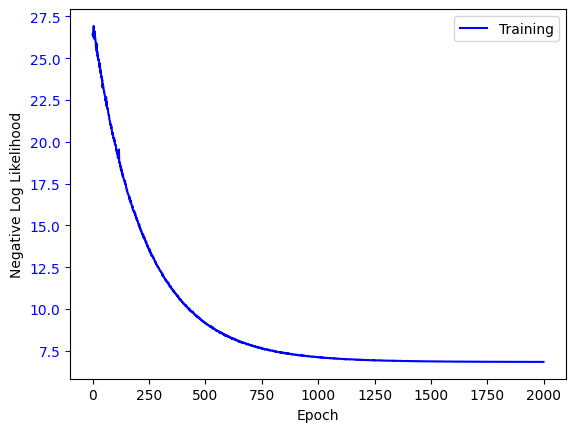

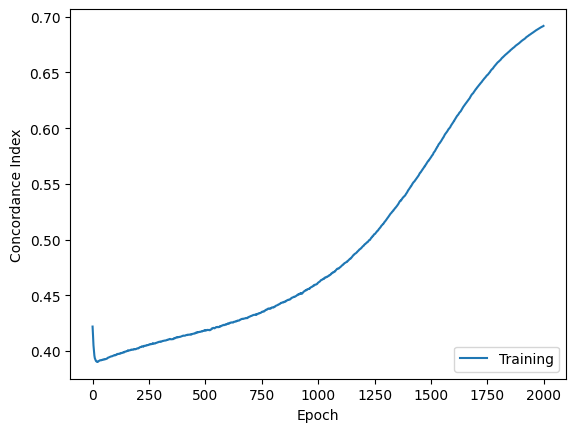

In [19]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)